In [ ]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# models
from lightgbm import LGBMClassifier

# XAI
import shap

import warnings


# config python file
import config

SEED = config.SEED
# INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 0

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [ ]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

In [ ]:
y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"][
    "y15"
].value_counts(), y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"][
    "y15"
].value_counts(), y_dict[
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
][
    "mrmr"
][
    "test"
][
    "y15"
].value_counts()

In [ ]:
optim_param_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/microarray_optim_params.pickle"
)
dict_optim_params = (
    pickle_load(optim_param_path) if os.path.exists(optim_param_path) else {}
)

In [4]:
X_train_global = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"][
    "X15"
]
y_train_global = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"][
    "y15"
]
X_val_global = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"][
    "X15"
]
y_val_global = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"][
    "y15"
]
X_test_global = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["test"][
    "X15"
]
y_test_global = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["test"][
    "y15"
]

assert X_train_global.shape[0] == y_train_global.shape[0], "train size is incorrect"
assert X_val_global.shape[0] == y_val_global.shape[0], "val size is incorrect"
assert X_test_global.shape[0] == y_test_global.shape[0], "test size is incorrect"

X_train_global = pd.concat([X_train_global, X_val_global])
y_train_global = pd.concat([y_train_global, y_val_global])
assert X_train_global.shape[1] == X_test_global.shape[1], "feature size is incorrect"

# accuracyの表示
print("-----train-----" * 10)
print("features: ", X_train_global.columns)
print("train size：", X_train_global.shape)
print("train acc baseline[0]: ", (y_train_global == 0).sum() / len(y_train_global))
print("train acc baseline[1]: ", (y_train_global == 1).sum() / len(y_train_global))
display("label ratio: ", y_train_global.value_counts())
print("-----test-----" * 10)
print("test size: ", X_test_global.shape)
print("test acc baseline[0]: ", (y_test_global == 0).sum() / len(y_test_global))
print("test acc baseline[1]: ", (y_test_global == 1).sum() / len(y_test_global))
display("label tario: ", y_test_global.value_counts())

-----train----------train----------train----------train----------train----------train----------train----------train----------train----------train-----
features:  Index(['RACGAP1', 'CYP2D6', 'PTX4', 'BIK', 'ENC1', 'DENND6A', 'STAT5B',
       'RNU11', 'DNAJB7', 'PPIL3', 'UHRF1', 'RBBP8', 'MIR137HG', 'GABRB1',
       'TOR1B', 'MST1', 'NMRK1', 'FGF13', 'HIST1H2BF', 'SPATA4', 'TBC1D31',
       'USP30', 'S100P', 'APLN', 'MTG2', 'GAL3ST4', 'FGD3', 'PJVK', 'INTS10',
       'CBX7', 'FCN2', 'RNASE9', 'SPATA18', 'ANKAR', 'SULT4A1', 'TSPYL6',
       'IGDCC4', 'TMEM26', 'PDK3', 'AURKA', 'PRR21', 'DNAAF1', 'GPR151',
       'GASK1A', 'NLRX1', 'RAB3B', 'HS3ST1', 'PKMYT1', 'CATSPERB'],
      dtype='object')
train size： (962, 49)
train acc baseline[0]:  0.46673596673596673
train acc baseline[1]:  0.5332640332640333


'label ratio: '

1    513
0    449
Name: OS_15years, dtype: int64

-----test----------test----------test----------test----------test----------test----------test----------test----------test----------test-----
test size:  (107, 49)
test acc baseline[0]:  0.4672897196261682
test acc baseline[1]:  0.5327102803738317


'label tario: '

1    57
0    50
Name: OS_15years, dtype: int64

# モデル作成 (all data)

In [5]:
def show_test_scores(
    clf: callable,
    clf_params,
    microarray_type: str,
    method: str,
    year: int,
    scaling: str = None,
):
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict[microarray_type][method]["train"][prognosis_Xlabel]
    y_train = y_dict[microarray_type][method]["train"][prognosis_ylabel]
    X_val = X_dict[microarray_type][method]["val"][prognosis_Xlabel]
    y_val = y_dict[microarray_type][method]["val"][prognosis_ylabel]
    X_test = X_dict[microarray_type][method]["test"][prognosis_Xlabel]
    y_test = y_dict[microarray_type][method]["test"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
    assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
    assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
    assert X_train.shape[1] == X_test.shape[1], "feature size is incorrect"

    X_train = pd.concat([X_train, X_val])
    y_train = pd.concat([y_train, y_val])

    if scaling == "sm":
        sm = SMOTE()
        X_train, y_train = sm.fit_resample(X_train, y_train)

    clf.set_params(**clf_params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    show_scores(y_test, y_pred)
    return clf

## random forest

In [6]:
params = {
    "n_estimators": 290,
    "max_depth": 12,
    "max_leaf_nodes": 100,
    "class_weight": "balanced_subsample",
    "random_state": SEED,
}


rf = show_test_scores(
    RandomForestClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
)
print("-----" * 10)
rf_sm = show_test_scores(
    RandomForestClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    "sm",
)

accuracy:  0.6355140186915887
precision:  0.6451612903225806
recall:  0.7017543859649122
f1 score:  0.6722689075630253
--------------------------------------------------
accuracy:  0.6261682242990654
precision:  0.6440677966101694
recall:  0.6666666666666666
f1 score:  0.6551724137931034


### dtree

In [7]:
viz = dtreeviz(
    rf_sm.estimators_[1],
    X_train_global,
    y_train_global,
    feature_names=X_train_global.columns,
    target_name="is_dead",
    class_names=["survived", "dead by cancer"],
)
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


### shap

In [8]:
# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_sm)
# Calculate SHAP values
shap_values = explainer.shap_values(X_train_global)
shap.force_plot(
    explainer.expected_value[0], shap_values[0], feature_names=X_train_global.columns
)

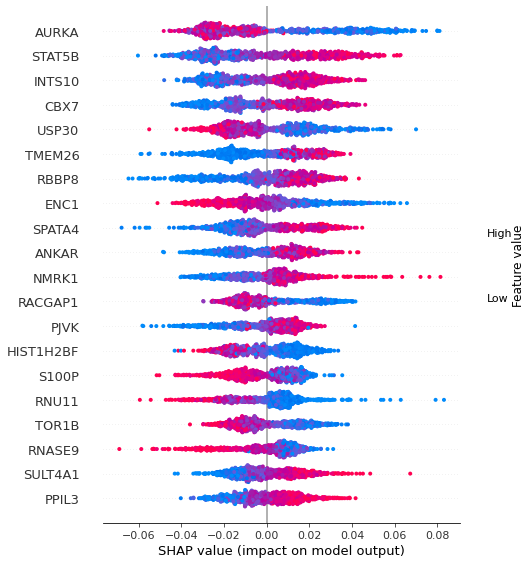

<Figure size 432x288 with 0 Axes>

In [9]:
shap.summary_plot(shap_values[0], X_train_global)
plt.tight_layout()

## Logistic Regression

accuracy:  0.6542056074766355
precision:  0.6785714285714286
recall:  0.6666666666666666
f1 score:  0.6725663716814159
--------------------------------------------------
accuracy:  0.6448598130841121
precision:  0.6727272727272727
recall:  0.6491228070175439
f1 score:  0.6607142857142858


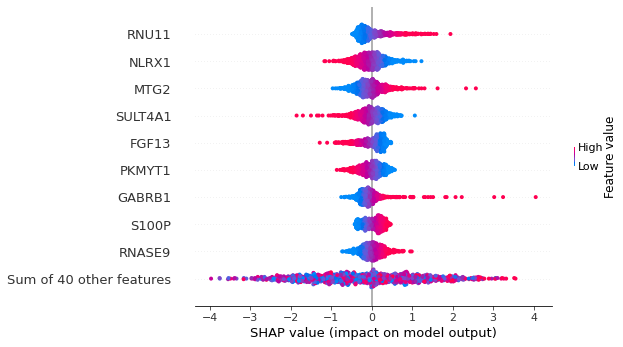

In [10]:
params = {
    "penalty": "l2",
    "C": 13670.65897712823,
    "class_weight": "balanced",
    "random_state": SEED,
}
lr = show_test_scores(
    LogisticRegression(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
)

print("-----" * 10)
lr_sm = show_test_scores(
    LogisticRegression(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    "sm",
)

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(lr, X_train_global, feature_names=X_train_global.columns)
shap_values = explainer(X_train_global)
shap.plots.beeswarm(explainer(X_train_global))

## lightGBM

In [ ]:
params = {
    "lambda_l1": 2.4349678475415957e-06,
    "lambda_l2": 0.05164946447927742,
    "max_bin": 113,
    "num_leaves": 44,
    "learning_rate": 0.00459386427957389,
    "n_estimators": 764,
    "class_weight": "balanced",
    "random_state": SEED,
}

gbm = show_test_scores(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
)
print("-----" * 10)
gbm_sm = show_test_scores(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    "sm",
)

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(gbm, X_train_global, feature_names=X_train_global.columns)
shap_values = explainer(X_train_global)
shap.plots.beeswarm(explainer(X_train_global))

## xgboost

In [78]:
import xgboost as xgb

xgb_train = xgb.DMatrix(
    X_train_global, label=y_train_global, feature_names=X_train_global.columns
)
xgb_test = xgb.DMatrix(
    X_test_global, label=y_test_global, feature_names=X_test_global.columns
)


param = {
    # 二値分類問題
    "objective": "binary:logistic",
}
clf = xgb.train(param, xgb_train)
y_pred_global_proba = clf.predict(xgb_test)
y_pred_global = np.where(y_pred_global_proba > 0.5, 1, 0)

accuracy_score(y_test_global, y_pred_global), f1_score(y_test_global, y_pred_global)

[06:48:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.5887850467289719, 0.6)

## SVM

In [ ]:
params = {
    "C": 31653.691881778464,
    "kernel": "linear",
    "gamma": "scale",
    "shrinking": False,
    "decision_function_shape": "ovr",
    "class_weight": "balanced",
    "random_state": SEED,
}

svm = show_test_scores(
    SVC(), params, config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], "mrmr", 15
)
print("-----" * 10)
svm_sm = show_test_scores(
    SVC(), params, config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], "mrmr", 15, "sm"
)

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
explainer = shap.Explainer(svm, X_train_global, feature_names=X_train_global.columns)
shap_values = explainer(X_train_global)
shap.plots.beeswarm(explainer(X_train_global))

# create ML model and interpret ML model (each subtypes)

In [13]:
dict_subtype_params = pickle_load(
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/subtype_params.pickle"
)

In [66]:
def prediction_subtype(
    clf: callable,
    clf_param_key: str,
    microarray_type: str,
    method: str,
    year: int,
    scaling: str = None,
):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for subtype in subtypes:
        print("==========" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)

        X_train_subtype = X_dict[microarray_type]["claudin_subtype"][method]["train"][
            prognosis_Xlabel
        ]
        y_train_subtype = y_dict[microarray_type]["claudin_subtype"][method]["train"][
            prognosis_ylabel
        ]
        X_val_subtype = X_dict[microarray_type]["claudin_subtype"][method]["val"][
            prognosis_Xlabel
        ]
        y_val_subtype = y_dict[microarray_type]["claudin_subtype"][method]["val"][
            prognosis_ylabel
        ]
        X_test_subtype = X_dict[microarray_type]["claudin_subtype"][method]["test"][
            prognosis_Xlabel
        ]
        y_test_subtype = y_dict[microarray_type]["claudin_subtype"][method]["test"][
            prognosis_ylabel
        ]

        assert (
            X_train_subtype.shape[0] == y_train_subtype.shape[0]
        ), "train size is incorrect"
        assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "val size is incorrect"
        assert (
            X_test_subtype.shape[0] == y_test_subtype.shape[0]
        ), "test size is incorrect"

        X_train_subtype = pd.concat([X_train_subtype, X_val_subtype])
        y_train_subtype = pd.concat([y_train_subtype, y_val_subtype])
        assert (
            X_train_subtype.shape[1] == X_test_subtype.shape[1]
        ), "feature size is incorrect"

        # accuracyの表示
        print("使用特徴量：", X_train_subtype.columns)
        print("学習サンプルサイズ：", X_train_subtype.shape)
        display("ラベル比率：", y_train_subtype.value_counts())
        print(
            "train acc baseline[0]: ",
            (y_train_subtype == 0).sum() / len(y_train_subtype),
        )
        print(
            "train acc baseline[1]: ",
            (y_train_subtype == 1).sum() / len(y_train_subtype),
        )
        print(
            "test acc baseline[0]: ", (y_test_subtype == 0).sum() / len(y_test_subtype)
        )
        print(
            "test acc baseline[1]: ", (y_test_subtype == 1).sum() / len(y_test_subtype)
        )

        # over sampling
        if scaling == "sm":
            sm = SMOTE()
            X_train_subtype, y_train_subtype = sm.fit_resample(
                X_train_subtype, y_train_subtype
            )

        # ML model params setting
        params = dict_subtype_params[clf_param_key][subtype][year]
        params["class_weight"] = "balanced"
        params["random_state"] = SEED

        # ML model
        # clf = clf(**params)
        clf.set_params(**params)
        clf.fit(X_train_subtype, y_train_subtype)  # train
        y_pred_subtype = clf.predict(X_test_subtype)  # prediction

        print(show_scores(y_test_subtype, y_pred_subtype))

In [68]:
print("---RF---" * 10)
prediction_subtype(
    clf=RandomForestClassifier(),
    clf_param_key="rf",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
)
print("---RF---" * 10)
prediction_subtype(
    clf=RandomForestClassifier(),
    clf_param_key="rf",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
    scaling="sm",
)

---RF------RF------RF------RF------RF------RF------RF------RF------RF------RF---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
accuracy:  0.6363636363636364
precision:  0.5714285714285714
recall:  0.8
f1 score:  0.6666666666666666
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
accuracy:  0.6764705882352942
precision:  0.6
recall:  0.46153846153846156
f1 score:  0.5217391304347826
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
accuracy:  0.7407407407407407
precision:  0.7894736842105263
recall:  0.8333333333333334
f1 score:  0.8108108108108109
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
accuracy:  0.5625
precision:  0.6666666666666666
recall:  0.7272727272727273
f1 score:  0.6956521739130435
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
accuracy:  0.625
precision:  0.6666666666666666
recall:  0.8
f1 score:  0.7272727272727272
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
accuracy:  0.46153846153846156
precision:  0.5555555555555556
recall:  0.625
f1 score:  0.5882352941176471
None
---RF------RF------RF------RF------RF------RF------RF------RF------RF------RF---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
accuracy:  0.5454545454545454
precision:  0.5
recall:  0.8
f1 score:  0.6153846153846154
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
accuracy:  0.6764705882352942
precision:  0.625
recall:  0.38461538461538464
f1 score:  0.4761904761904762
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
accuracy:  0.7037037037037037
precision:  0.8125
recall:  0.7222222222222222
f1 score:  0.7647058823529411
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
accuracy:  0.625
precision:  0.7272727272727273
recall:  0.7272727272727273
f1 score:  0.7272727272727273
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
accuracy:  0.5
precision:  0.5714285714285714
recall:  0.8
f1 score:  0.6666666666666666
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
accuracy:  0.46153846153846156
precision:  0.5714285714285714
recall:  0.5
f1 score:  0.5333333333333333
None


In [67]:
print("---LR---" * 10)
prediction_subtype(
    clf=LogisticRegression(),
    clf_param_key="lr",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
)
print("---LR---" * 10)
prediction_subtype(
    clf=LogisticRegression(),
    clf_param_key="lr",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
    scaling="sm",
)

---LR------LR------LR------LR------LR------LR------LR------LR------LR------LR---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
accuracy:  0.6363636363636364
precision:  0.6666666666666666
recall:  0.4
f1 score:  0.5
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
accuracy:  0.5294117647058824
precision:  0.4
recall:  0.46153846153846156
f1 score:  0.42857142857142855
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
accuracy:  0.7037037037037037
precision:  0.8125
recall:  0.7222222222222222
f1 score:  0.7647058823529411
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
accuracy:  0.625
precision:  0.7777777777777778
recall:  0.6363636363636364
f1 score:  0.7000000000000001
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
accuracy:  0.5
precision:  0.6
recall:  0.6
f1 score:  0.6
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
accuracy:  0.38461538461538464
precision:  0.5
recall:  0.375
f1 score:  0.42857142857142855
None
---LR------LR------LR------LR------LR------LR------LR------LR------LR------LR---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
accuracy:  0.6363636363636364
precision:  0.6666666666666666
recall:  0.4
f1 score:  0.5
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
accuracy:  0.5294117647058824
precision:  0.4
recall:  0.46153846153846156
f1 score:  0.42857142857142855
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
accuracy:  0.7037037037037037
precision:  0.8125
recall:  0.7222222222222222
f1 score:  0.7647058823529411
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
accuracy:  0.6875
precision:  0.8
recall:  0.7272727272727273
f1 score:  0.761904761904762
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
accuracy:  0.5
precision:  0.6
recall:  0.6
f1 score:  0.6
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
accuracy:  0.38461538461538464
precision:  0.5
recall:  0.375
f1 score:  0.42857142857142855
None


In [69]:
print("---LGB---" * 10)
prediction_subtype(
    clf=LGBMClassifier(),
    clf_param_key="lgb",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
)
print("---LGB---" * 10)
prediction_subtype(
    clf=LGBMClassifier(),
    clf_param_key="lgb",
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    year=15,
    scaling="sm",
)

---LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
accuracy:  0.7272727272727273
precision:  0.6666666666666666
recall:  0.8
f1 score:  0.7272727272727272
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
[LightGBM] [Warning] lambda_l1 is set=0.0005666024510877596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005666024510877596
[LightGBM] [Warning] lambda_l2 is set=0.0004144178511888125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004144178511888125
accuracy:  0.5882352941176471
precision:  0.4444444444444444
recall:  0.3076923076923077
f1 score:  0.3636363636363637
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
[LightGBM] [Warning] lambda_l1 is set=2.2990734327410567e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2990734327410567e-05
[LightGBM] [Warning] lambda_l2 is set=3.0290683008644125e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0290683008644125e-05
accuracy:  0.7037037037037037
precision:  0.75
recall:  0.8333333333333334
f1 score:  0.7894736842105262
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
[LightGBM] [Warning] lambda_l1 is set=0.000670880035771874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000670880035771874
[LightGBM] [Warning] lambda_l2 is set=0.0030017148105112024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030017148105112024
accuracy:  0.5625
precision:  0.75
recall:  0.5454545454545454
f1 score:  0.631578947368421
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
[LightGBM] [Warning] lambda_l1 is set=1.4335872529773278e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4335872529773278e-07
[LightGBM] [Warning] lambda_l2 is set=0.06846703963464537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06846703963464537
accuracy:  0.5
precision:  0.6
recall:  0.6
f1 score:  0.6
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
[LightGBM] [Warning] lambda_l1 is set=1.5809724025403666e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5809724025403666e-06
[LightGBM] [Warning] lambda_l2 is set=2.4389821801052975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4389821801052975
accuracy:  0.46153846153846156
precision:  0.5714285714285714
recall:  0.5
f1 score:  0.5333333333333333
None
---LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB------LGB---
claudin-low
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (99, 20)


'ラベル比率：'

0    56
1    43
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.5656565656565656
train acc baseline[1]:  0.43434343434343436
test acc baseline[0]:  0.5454545454545454
test acc baseline[1]:  0.45454545454545453
[LightGBM] [Warning] lambda_l1 is set=2.468397929794942e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468397929794942e-07
[LightGBM] [Warning] lambda_l2 is set=1.1386803617697432e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1386803617697432e-08
accuracy:  0.6363636363636364
precision:  0.5714285714285714
recall:  0.8
f1 score:  0.6666666666666666
None
LumA
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (306, 20)


'ラベル比率：'

0    193
1    113
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.630718954248366
train acc baseline[1]:  0.369281045751634
test acc baseline[0]:  0.6176470588235294
test acc baseline[1]:  0.38235294117647056
[LightGBM] [Warning] lambda_l1 is set=0.0005666024510877596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005666024510877596
[LightGBM] [Warning] lambda_l2 is set=0.0004144178511888125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004144178511888125
accuracy:  0.5882352941176471
precision:  0.45454545454545453
recall:  0.38461538461538464
f1 score:  0.41666666666666663
None
LumB
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (237, 20)


'ラベル比率：'

1    154
0     83
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.350210970464135
train acc baseline[1]:  0.6497890295358649
test acc baseline[0]:  0.3333333333333333
test acc baseline[1]:  0.6666666666666666
[LightGBM] [Warning] lambda_l1 is set=2.2990734327410567e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2990734327410567e-05
[LightGBM] [Warning] lambda_l2 is set=3.0290683008644125e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0290683008644125e-05
accuracy:  0.7037037037037037
precision:  0.7777777777777778
recall:  0.7777777777777778
f1 score:  0.7777777777777778
None
Her2
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (136, 20)


'ラベル比率：'

1    92
0    44
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.3235294117647059
train acc baseline[1]:  0.6764705882352942
test acc baseline[0]:  0.3125
test acc baseline[1]:  0.6875
[LightGBM] [Warning] lambda_l1 is set=0.000670880035771874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000670880035771874
[LightGBM] [Warning] lambda_l2 is set=0.0030017148105112024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030017148105112024
accuracy:  0.5625
precision:  0.7
recall:  0.6363636363636364
f1 score:  0.6666666666666666
None
Normal
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (65, 20)


'ラベル比率：'

1    37
0    28
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.4307692307692308
train acc baseline[1]:  0.5692307692307692
test acc baseline[0]:  0.375
test acc baseline[1]:  0.625
[LightGBM] [Warning] lambda_l1 is set=1.4335872529773278e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4335872529773278e-07
[LightGBM] [Warning] lambda_l2 is set=0.06846703963464537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06846703963464537
accuracy:  0.625
precision:  0.6666666666666666
recall:  0.8
f1 score:  0.7272727272727272
None
Basal
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (117, 20)


'ラベル比率：'

1    71
0    46
Name: OS_15years, dtype: int64

train acc baseline[0]:  0.39316239316239315
train acc baseline[1]:  0.6068376068376068
test acc baseline[0]:  0.38461538461538464
test acc baseline[1]:  0.6153846153846154
[LightGBM] [Warning] lambda_l1 is set=1.5809724025403666e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5809724025403666e-06
[LightGBM] [Warning] lambda_l2 is set=2.4389821801052975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4389821801052975
accuracy:  0.46153846153846156
precision:  0.5714285714285714
recall:  0.5
f1 score:  0.5333333333333333
None
